## IMPORTS

In [344]:
import pandas as pd # Data preperation and data readings 
import numpy as np 
import matplotlib.pyplot as plt # Plots
import seaborn as sb # Prettier plots
import folium # Maps
from branca.element import Figure

## WILDFIRE DATASET

### California Fire Incidents Data Prep

In [345]:
ds = pd.read_csv("California_Fire_Incidents.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1633 non-null   float64
 1   Active                1636 non-null   bool   
 2   AdminUnit             1636 non-null   object 
 3   AirTankers            28 non-null     float64
 4   ArchiveYear           1636 non-null   int64  
 5   CalFireIncident       1636 non-null   bool   
 6   CanonicalUrl          1636 non-null   object 
 7   ConditionStatement    284 non-null    object 
 8   ControlStatement      111 non-null    object 
 9   Counties              1636 non-null   object 
 10  CountyIds             1636 non-null   object 
 11  CrewsInvolved         171 non-null    float64
 12  Dozers                123 non-null    float64
 13  Engines               191 non-null    float64
 14  Extinguished          1577 non-null   object 
 15  Fatalities           

In [346]:
firedep_ds = pd.read_excel("CalFireDepartments.xlsx")

firedep_ds.head()

Department Name   Latitude   Longitude
0          Butte County Unit  39.644268 -121.800067
1  San Mateo-Santa Cruz Unit  37.512188 -122.338668
2          Fresno Kings Unit  36.676022 -119.616011
3          Lassen-Modoc Unit  40.424895 -120.677065
4             San Diego Unit  32.749183 -116.926775

In [347]:
cols=["Location", "SearchDescription", "SearchKeywords", 
"CanonicalUrl", "Final", "Featured", "FuelType", "Updated", 
"StructuresEvacuated", "Active", "ConditionStatement", 
"ControlStatement", "Public", "PercentContained", "Status"]
ds_copy = ds.copy()

ds_copy = ds_copy.drop(cols, axis = 1)
ds_copy["Extinguished"] = pd.to_datetime(ds_copy["Extinguished"])
ds_copy["Started"] = pd.to_datetime(ds_copy["Started"])
ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   AcresBurned           1633 non-null   float64            
 1   AdminUnit             1636 non-null   object             
 2   AirTankers            28 non-null     float64            
 3   ArchiveYear           1636 non-null   int64              
 4   CalFireIncident       1636 non-null   bool               
 5   Counties              1636 non-null   object             
 6   CountyIds             1636 non-null   object             
 7   CrewsInvolved         171 non-null    float64            
 8   Dozers                123 non-null    float64            
 9   Engines               191 non-null    float64            
 10  Extinguished          1577 non-null   datetime64[ns, UTC]
 11  Fatalities            21 non-null     float64            
 12  Helico

In [348]:
# Segmentating data and adding aditional information.

# Add the time of the fire duration.
ds_copy["FireDuration"] = -(ds_copy["Started"]-ds_copy["Extinguished"])

#Segmentating the data based on how big (how many acres burned) the wild fire is.
meanAcresBurned = ds_copy["AcresBurned"].mean()
ds_copy.loc[ds_copy["AcresBurned"]>meanAcresBurned+10000, "WildfireSize"] = "BigWildfire"
ds_copy.loc[ds_copy["AcresBurned"]<=meanAcresBurned+10000, "WildfireSize"] = "AvgWildfire"
ds_copy.loc[ds_copy["AcresBurned"]<=meanAcresBurned-2000, "WildfireSize"] = "SmallWildfire"
ds_copy.head()

AcresBurned                                          AdminUnit  AirTankers  \
0     257314.0  Stanislaus National Forest/Yosemite National Park         NaN   
1      30274.0  USFS Angeles National Forest/Los Angeles Count...         NaN   
2      27531.0  CAL FIRE Riverside Unit / San Bernardino Natio...         NaN   
3      27440.0                              Tahoe National Forest         NaN   
4      24251.0                       Ventura County Fire/CAL FIRE         NaN   

   ArchiveYear  CalFireIncident     Counties CountyIds  CrewsInvolved  Dozers  \
0         2013             True     Tuolumne        55            NaN     NaN   
1         2013             True  Los Angeles        19            NaN     NaN   
2         2013             True    Riverside        33            NaN     NaN   
3         2013            False       Placer        31            NaN     NaN   
4         2013             True      Ventura        56           47.0     8.0   

   Engines  ...             Name  PersonnelInvolved                   Started  \
0      NaN  ...         Rim Fire                NaN 2013-08-17 15:25:00+00:00   
1      NaN  ...  Powerhouse Fire                NaN 2013-05-30 15:28:00+00:00   
2      NaN  ...    Mountain Fire                NaN 2013-07-15 13:43:00+00:00   
3      NaN  ...    American Fire                NaN 2013-08-10 16:30:00+00:00   
4    117.0  ...     Springs Fire             2167.0 2013-05-02 07:01:00+00:00   

   StructuresDamaged  StructuresDestroyed  StructuresThreatened  \
0                NaN                  NaN                   NaN   
1                NaN                  NaN                   NaN   
2                NaN                  NaN                   NaN   
3                NaN                  NaN                   NaN   
4                6.0                 10.0                   NaN   

                               UniqueId WaterTenders     FireDuration  \
0  5fb18d4d-213f-4d83-a179-daaf11939e78          NaN 20 days 03:05:00   
1  bf37805e-1cc2-4208-9972-753e47874c87          NaN  9 days 03:02:00   
2  a3149fec-4d48-427c-8b2c-59e8b79d59db          NaN 15 days 04:17:00   
3  8213f5c7-34fa-403b-a4bc-da2ace6e6625          NaN 19 days 15:30:00   
4  46731fb8-3350-4920-bdf7-910ac0eb715c         11.0  8 days 23:29:00   

  WildfireSize  
0  BigWildfire  
1  BigWildfire  
2  BigWildfire  
3  BigWildfire  
4  BigWildfire  

[5 rows x 27 columns]

In [349]:
# Add additional column with bool value where the av fire duration is lower than the mean of dataset without outliers.
lowerOutlier = ds_copy["FireDuration"].quantile(0.05) # Remove lower outliers
upperOutlier = ds_copy["FireDuration"].quantile(0.95) # Remove upper outliers
ds_copy1 = ds_copy[(ds_copy["FireDuration"]>lowerOutlier) & (ds_copy["FireDuration"]<upperOutlier)] # New dataset for mean without outliers
meanFireDuration = ds_copy1["FireDuration"].mean() # Mean of new dataset

ds_copy.loc[ds_copy["FireDuration"]>meanFireDuration, "Fast Extinguishing"] = False
ds_copy.loc[ds_copy["FireDuration"]<=meanFireDuration, "Fast Extinguishing"] = True

# map values 0 to false and 1 to true
ds_copy["Fast Extinguishing"] = ds_copy["Fast Extinguishing"].astype("bool")
ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   AcresBurned           1633 non-null   float64            
 1   AdminUnit             1636 non-null   object             
 2   AirTankers            28 non-null     float64            
 3   ArchiveYear           1636 non-null   int64              
 4   CalFireIncident       1636 non-null   bool               
 5   Counties              1636 non-null   object             
 6   CountyIds             1636 non-null   object             
 7   CrewsInvolved         171 non-null    float64            
 8   Dozers                123 non-null    float64            
 9   Engines               191 non-null    float64            
 10  Extinguished          1577 non-null   datetime64[ns, UTC]
 11  Fatalities            21 non-null     float64            
 12  Helico

In [350]:
# Drop rows where the longitude and latitude is outside California
# California Latitude: 32 to 42
# California Longitude: -114 to -124
ds_copy = ds_copy[ds_copy.Latitude>32]
ds_copy = ds_copy[ds_copy.Latitude<42]
ds_copy = ds_copy[ds_copy.Longitude<-114]
ds_copy = ds_copy[ds_copy.Longitude>-124]

### California Fire Incidents Modeling

Text(0, 0.5, 'Amount of Wildfires')

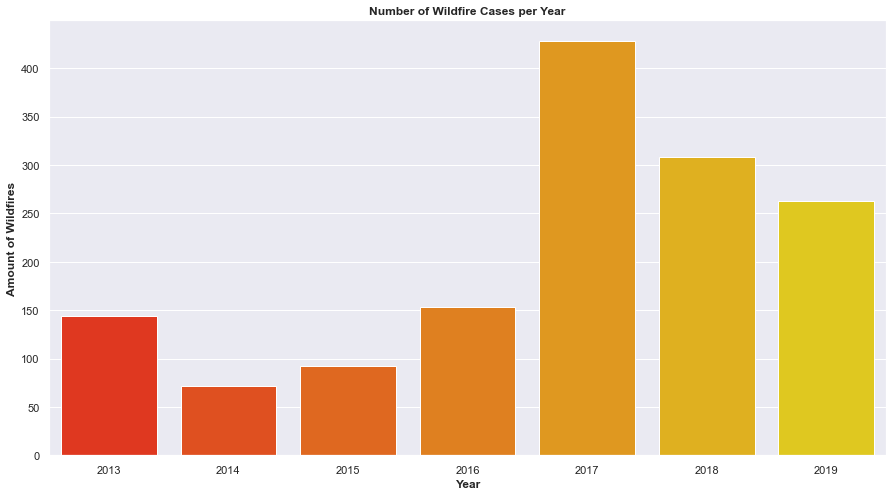

In [351]:
# Number of wildfires per year
plt.title("Number of Wildfire Cases per Year", fontdict=dict(weight='bold'))
numWildfires = sb.countplot(x="ArchiveYear", data=ds_copy, palette="autumn")
numWildfires.set_xlabel(xlabel='Year', fontdict=dict(weight='bold'))
numWildfires.set_ylabel(ylabel='Amount of Wildfires', fontdict=dict(weight='bold'))

Text(0, 0.5, 'Acres Burned')

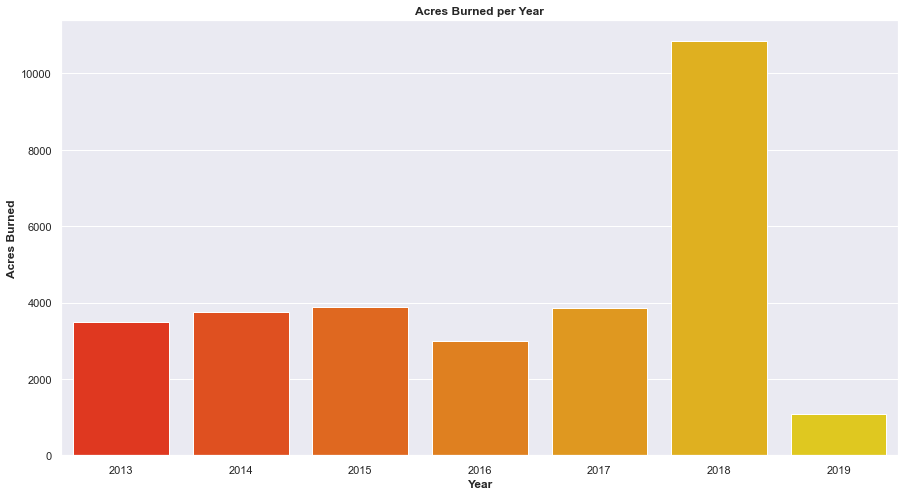

In [352]:
plt.title("Acres Burned per Year", fontdict=dict(weight="bold"))
acresBurnedPerYear = sb.barplot(x="ArchiveYear", y="AcresBurned", data=ds_copy, ci=0, palette="autumn")
acresBurnedPerYear.set_xlabel(xlabel= "Year", fontdict=dict(weight='bold'))
acresBurnedPerYear.set_ylabel(ylabel='Acres Burned', fontdict=dict(weight='bold'))

Text(0, 0.5, 'Amount of Wildfires cases')

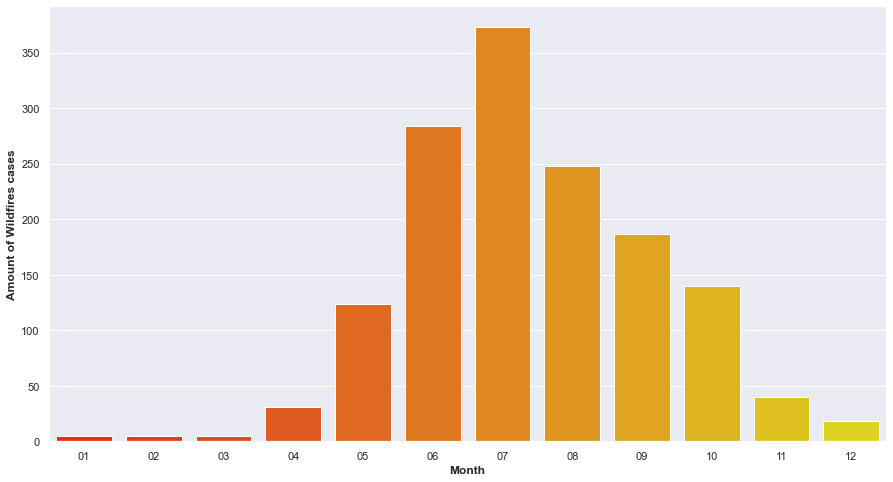

In [353]:
ds_copy["ArchiveMonth"] = ds_copy["Started"].dt.strftime('%m')
months = ds_copy["ArchiveMonth"].unique()
ax = sb.countplot(x="ArchiveMonth", data=ds_copy, palette="autumn", order=sorted(months))
ax.set_xlabel(xlabel='Month', fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Amount of Wildfires cases', fontdict=dict(weight='bold'))

Text(0, 0.5, 'Amount of Wildfires cases')

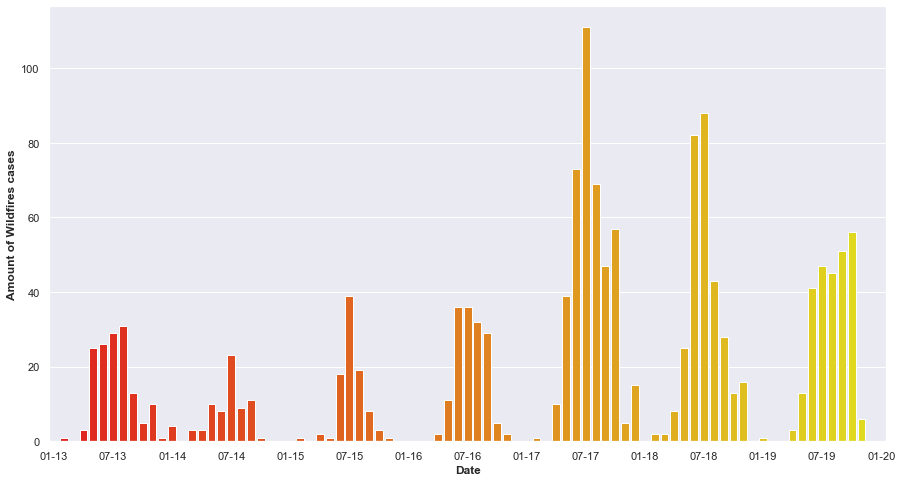

In [354]:
from dateutil.relativedelta import relativedelta
import datetime
ds_copy["ArchiveDate"] = ds_copy["Started"].dt.strftime('%m-%y')
df_ArchiveDate = ds_copy["ArchiveDate"].value_counts(sort=False)

dict_ArchiveDate = dict()

# Add all months from Jan 2013 to Jan 2020. 
current = datetime.date(2013,1,1)
end = datetime.date(2020, 1, 1)

while current <= end:
    date = current.strftime('%m-%y')
    numberToAdd = df_ArchiveDate.get(date)
    if numberToAdd == None:
        numberToAdd = 0
    dict_ArchiveDate[date] = numberToAdd  # Add amount of cases for that month into dictionary
    current += relativedelta(months=1) 

# Create DataFrame from dictionary
data = list(dict_ArchiveDate.items())
dates_df = pd.DataFrame(data, columns=["Date", "DateValues"])
sb.set(rc={"figure.figsize": (15,8)})
ax = sb.barplot(x="Date", y="DateValues", data=dates_df, palette="autumn")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xlabel(xlabel='Date', fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Amount of Wildfires cases', fontdict=dict(weight='bold'))

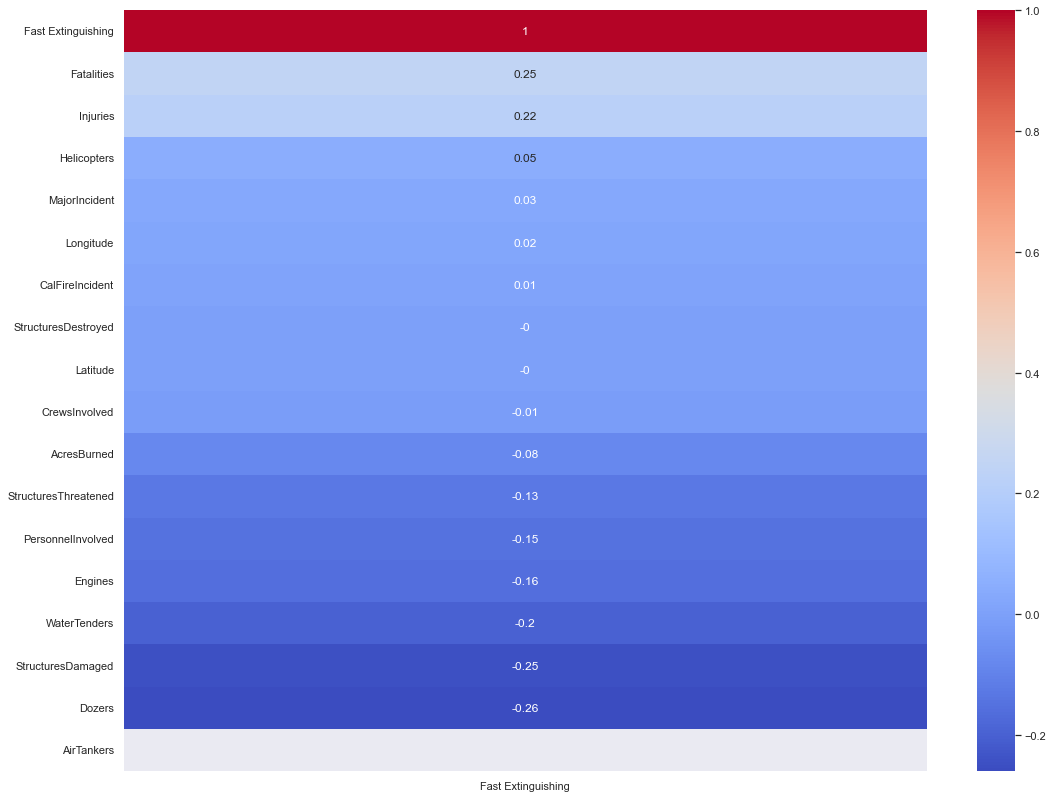

In [355]:
# Correlation between columns and "Fast Extinguishing"
corr_ds = ds_copy.drop(["UniqueId", "Counties", "CountyIds", "Extinguished", "Started", "Name", "FireDuration", "AdminUnit", "WildfireSize", "ArchiveYear"], axis=1)
x = round(corr_ds.corr(),2)
plt.figure(figsize=(18,14))
sb.heatmap(x[["Fast Extinguishing"]].sort_values(by=["Fast Extinguishing"], ascending=False), cmap='coolwarm', annot=True)
plt.show()

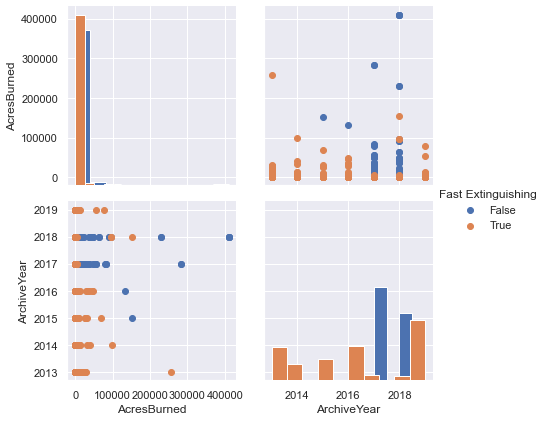

In [356]:
# Pair plot columns from the dataset and show for which wildfire size they are from
pairplot = sb.PairGrid(data=ds_copy, vars = ["AcresBurned", "ArchiveYear"], hue="Fast Extinguishing", height=3)
pairplot.map_diag(plt.hist)
pairplot.map_offdiag(plt.scatter)
pairplot.add_legend()

### California Fire Incidents Mapping

In [357]:
# Create a folium map and place a circle in the map for each of the wildfires from 2013-2020 with a larger radius depending on how big the wildfire was 
# ; uncomment the layercontrol line if you want other maptypes
fig=Figure(width=550,height=350)

map = folium.Map(location=[36.778259, -119.417931], zoom_start=5)
fig.add_child(map)
folium.TileLayer('Stamen Terrain').add_to(map)
#folium.LayerControl().add_to(map)
for i in range (0, ds_copy.shape[0]):
  r = np.sqrt(ds_copy.iloc[i]["AcresBurned"])*20
  folium.Circle(location=[ds_copy.iloc[i]["Latitude"], ds_copy.iloc[i]["Longitude"]], radius=r, color = "red", fill_color = "orange").add_to(map)
map

In [358]:
# Create a folium map for each of the wildfires under the category of "BigWildfire"; uncomment the layercontrol line if you want other maptypes
from folium.plugins import MarkerCluster
fig2=Figure(width=550,height=350)

bigFireMap = folium.Map(location=[36.778259, -119.417931], zoom_start=5)
cluster_marker = MarkerCluster().add_to(bigFireMap)
fig2.add_child(bigFireMap)
folium.TileLayer('Stamen Terrain').add_to(bigFireMap)
#folium.LayerControl().add_to(bigFireMap)
for i in range (0, ds_copy.shape[0]):
  r = np.sqrt(ds_copy.iloc[i]["AcresBurned"])/20
  if ds_copy.iloc[i]["WildfireSize"] == "BigWildfire":
    folium.CircleMarker(location=[ds_copy.iloc[i]["Latitude"], ds_copy.iloc[i]["Longitude"]], radius=r, color = "red", fill_color = "orange").add_to(cluster_marker)
bigFireMap

In [359]:
# Heat maps with visualization of County CAL units
from folium import plugins
from folium.plugins import HeatMap
fig3=Figure(width=550,height=350)

heat_map = folium.Map(location=[36,-120], zoom_start=5)

fig3.add_child(heat_map)
folium.TileLayer('Stamen Terrain').add_to(heat_map)

HeatMap(data=ds_copy[['Latitude', 'Longitude']], radius=15).add_to(folium.FeatureGroup(name='Heat Map').add_to(heat_map))
folium.LayerControl().add_to(heat_map)
for i in range (0, firedep_ds.shape[0]):
    #folium.Circle(location=[firedep_ds.iloc[i]["Latitude"], firedep_ds.iloc[i]["Longitude"]], radius=500, color = "black", fill=True, fill_opacity= 1, tooltip=firedep_ds.iloc[i]["Department Name"]).add_to(heat_map)
    folium.map.Marker(location=[firedep_ds.iloc[i]["Latitude"], firedep_ds.iloc[i]["Longitude"]], icon=folium.Icon(color="black", icon="fire-extinguisher", prefix="fa"), tooltip=firedep_ds.iloc[i]["Department Name"]).add_to(heat_map)
heat_map # display

In [360]:
# Clustering of all wildfires from 2013 to 2020 with CAL FIRE firestations shown as markers.
fig=Figure(width=550,height=350)

hot_spot = folium.Map(location=[36.778259, -119.417931], zoom_start=5)
cluster_marker = MarkerCluster().add_to(hot_spot)
fig.add_child(hot_spot)
folium.TileLayer('Stamen Terrain').add_to(hot_spot)
#folium.LayerControl().add_to(map)
for i in range (0, ds_copy.shape[0]):
  r = np.sqrt(ds_copy.iloc[i]["AcresBurned"])/50
  folium.CircleMarker(location=[ds_copy.iloc[i]["Latitude"], ds_copy.iloc[i]["Longitude"]], radius=r, color = "red", fill_color = "orange").add_to(cluster_marker)

#for i in range (0, firedep_ds.shape[0]):
    #folium.Circle(location=[firedep_ds.iloc[i]["Latitude"], firedep_ds.iloc[i]["Longitude"]], radius=500, color = "black", fill=True, fill_opacity= 1, tooltip=firedep_ds.iloc[i]["Department Name"]).add_to(heat_map)
    #folium.map.Marker(location=[firedep_ds.iloc[i]["Latitude"], firedep_ds.iloc[i]["Longitude"]], icon=folium.Icon(color="black", icon="fire-extinguisher", prefix="fa"), tooltip=firedep_ds.iloc[i]["Department Name"]).add_to(hot_spot)
hot_spot

In [361]:
# Heat maps with visualization per year
from folium import plugins
from folium.plugins import HeatMap
fig3=Figure(width=550,height=350)

heat_map2 = folium.Map(location=[36,-120], zoom_start=5)

fig3.add_child(heat_map2)
folium.TileLayer('Stamen Terrain').add_to(heat_map2)

for val in ds_copy["ArchiveYear"].unique():
    df = ds_copy[ds_copy.ArchiveYear == val]
    HeatMap(data=df[['Latitude', 'Longitude']], radius=15).add_to(folium.FeatureGroup(name=str(val), show=False).add_to(heat_map2))


folium.LayerControl().add_to(heat_map2)

heat_map2

In [362]:
# Clustering of wildfires per year
from folium import plugins
fig=Figure(width=550,height=350)

hot_spot2 = folium.Map(location=[36.778259, -119.417931], zoom_start=5)
fig.add_child(hot_spot2)
folium.TileLayer('Stamen Terrain').add_to(hot_spot2)

for val in ds_copy["ArchiveYear"].unique():
  df = ds_copy[ds_copy.ArchiveYear == val]
  cluster_marker2 = MarkerCluster(name=str(val), show=False).add_to(hot_spot2)
  for i in range (0, df.shape[0]):
    r = np.sqrt(df.iloc[i]["AcresBurned"])/50
    folium.CircleMarker(location=[df.iloc[i]["Latitude"], df.iloc[i]["Longitude"]], radius=r, color = "red", fill_color = "orange").add_to(cluster_marker2)

folium.LayerControl().add_to(hot_spot2)

hot_spot2

## WEATHER CALIFORNIA DATASET

### Weather dataset

In [363]:
weather_ds = pd.read_csv("weather-data-2014-2019.csv",header=None)
weather_ds_copy = weather_ds.copy()
weather_ds_copy.drop(weather_ds.columns[[2,3,4,6,7,8,9,10,12,14,16,18,20,22,23,24,25,26,27,28,29,30]],axis=1,inplace=True)
weather_ds_copy.head()

C:\Users\Trym\Anaconda3\envs\california\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0         1  5     11    13    15  17  19  21
0  2  1/1/2014  0  64.7  29.4  44.2  74  30  53
1  2  1/2/2014  0  63.9  28.2  44.3  68  31  51
2  2  1/3/2014  0  64.1    30    45  75  31  53
3  2  1/4/2014  0  63.5  31.3  44.6  74  32  54
4  2  1/5/2014  0  64.4  29.1  44.4  72  34  57

In [364]:
weather_ds_copy.columns = ['Station_Number', 'Date', 'Precipitation','Maximum Air Temperature','Minimum Air Temperature','Average Air Temperature','Maximum Relative Humidity','Minimum Relative Humidity','Average Relative Humidity']
weather_ds_copy = weather_ds_copy[:-1]
weather_ds_copy.head()

Station_Number      Date Precipitation Maximum Air Temperature  \
0              2  1/1/2014             0                    64.7   
1              2  1/2/2014             0                    63.9   
2              2  1/3/2014             0                    64.1   
3              2  1/4/2014             0                    63.5   
4              2  1/5/2014             0                    64.4   

  Minimum Air Temperature Average Air Temperature Maximum Relative Humidity  \
0                    29.4                    44.2                        74   
1                    28.2                    44.3                        68   
2                      30                      45                        75   
3                    31.3                    44.6                        74   
4                    29.1                    44.4                        72   

  Minimum Relative Humidity Average Relative Humidity  
0                        30                        53  
1                        31                        51  
2                        31                        53  
3                        32                        54  
4                        34                        57

In [365]:
for column in ['Minimum Air Temperature','Maximum Air Temperature','Average Air Temperature']:
    new_temperature = []
    for v in weather_ds_copy[column]:
        if v == '--':
            new_temperature.append(None)
            continue
        celsius = round((float(v)-32) * (5/9),1)
        new_temperature.append(celsius)
    weather_ds_copy[column] = new_temperature
weather_ds_copy.head(100)

Station_Number       Date Precipitation  Maximum Air Temperature  \
0               2   1/1/2014             0                     18.2   
1               2   1/2/2014             0                     17.7   
2               2   1/3/2014             0                     17.8   
3               2   1/4/2014             0                     17.5   
4               2   1/5/2014             0                     18.0   
..            ...        ...           ...                      ...   
95              2   4/6/2014             0                     23.8   
96              2   4/7/2014             0                     31.6   
97              2   4/8/2014             0                     32.3   
98              2   4/9/2014             0                     31.3   
99              2  4/10/2014             0                     30.3   

    Minimum Air Temperature  Average Air Temperature  \
0                      -1.4                      6.8   
1                      -2.1                      6.8   
2                      -1.1                      7.2   
3                      -0.4                      7.0   
4                      -1.6                      6.9   
..                      ...                      ...   
95                      5.6                     15.4   
96                      7.9                     19.1   
97                     11.5                     21.6   
98                     11.3                     22.1   
99                     11.3                     21.9   

   Maximum Relative Humidity Minimum Relative Humidity  \
0                         74                        30   
1                         68                        31   
2                         75                        31   
3                         74                        32   
4                         72                        34   
..                       ...                       ...   
95                        78                        31   
96                        79                        20   
97                        71                        13   
98                        67                        15   
99                        67                        20   

   Average Relative Humidity  
0                         53  
1                         51  
2                         53  
3                         54  
4                         57  
..                       ...  
95                        52  
96                        44  
97                        37  
98                        36  
99                        35  

[100 rows x 9 columns]

In [366]:
weather_ds_copy["Date"] = pd.to_datetime(weather_ds_copy["Date"])
weather_ds_copy.head()

Station_Number       Date Precipitation  Maximum Air Temperature  \
0              2 2014-01-01             0                     18.2   
1              2 2014-01-02             0                     17.7   
2              2 2014-01-03             0                     17.8   
3              2 2014-01-04             0                     17.5   
4              2 2014-01-05             0                     18.0   

   Minimum Air Temperature  Average Air Temperature Maximum Relative Humidity  \
0                     -1.4                      6.8                        74   
1                     -2.1                      6.8                        68   
2                     -1.1                      7.2                        75   
3                     -0.4                      7.0                        74   
4                     -1.6                      6.9                        72   

  Minimum Relative Humidity Average Relative Humidity  
0                        30                        53  
1                        31                        51  
2                        31                        53  
3                        32                        54  
4                        34                        57

In [367]:
float_value_list = ["Maximum Air Temperature", "Minimum Air Temperature", "Precipitation", "Average Air Temperature", "Maximum Relative Humidity", "Minimum Relative Humidity", "Average Relative Humidity"]
for val in float_value_list:
    weather_ds_copy[val] = pd.to_numeric(weather_ds_copy[val],errors='coerce')

In [368]:
weather_ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324277 entries, 0 to 324276
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Station_Number             324277 non-null  object        
 1   Date                       324277 non-null  datetime64[ns]
 2   Precipitation              318967 non-null  float64       
 3   Maximum Air Temperature    317438 non-null  float64       
 4   Minimum Air Temperature    316752 non-null  float64       
 5   Average Air Temperature    317562 non-null  float64       
 6   Maximum Relative Humidity  318538 non-null  float64       
 7   Minimum Relative Humidity  318538 non-null  float64       
 8   Average Relative Humidity  312044 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 22.3+ MB


### Station dataset

In [369]:
station_ds = pd.read_excel('CIMIS Stations List (January20).xlsx')
station_ds = station_ds[:-1]
station_ds

Station_Number DWR Regional Office*                  Name      County  \
0               1.0                 SCRO    Fresno/F.S.U. USDA      Fresno   
1               2.0                 SCRO         Five Points        Fresno   
2               3.0                 SCRO  Beach /Santa Cruz CO  Santa Cruz   
3               4.0                 SCRO   Webb /Santa Cruz CO  Santa Cruz   
4               5.0                 SCRO          Shafter/USDA        Kern   
..              ...                  ...                   ...         ...   
256           257.0                  SRO            Ridgecrest        Kern   
257           258.0                 SCRO            Lemon Cove      Tulare   
258           259.0                  NRO        Ferndale Plain    Humboldt   
259           260.0                  NRO              Montague    Siskiyou   
260           261.0                  NRO               Gazelle    Siskiyou   

      Latitude   Longitude    ELEV    Status    Connect           Disconnect  
0    36.814000 -119.732000   340.0  Inactive 1982-06-07  1988-09-25 00:00:00  
1    36.336222 -120.112906   285.0    Active 1982-06-07               Active  
2    36.881000 -121.793000    10.0  Inactive 1982-05-30  1986-08-25 00:00:00  
3    36.972000 -121.726000   230.0  Inactive 1982-05-30  1988-04-29 00:00:00  
4    35.532695 -119.281862   360.0    Active 1982-06-01               Active  
..         ...         ...     ...       ...        ...                  ...  
256  35.659128 -117.636925  2234.0    Active 2018-10-10               Active  
257  36.376917 -119.037972   498.0    Active 2018-11-15               Active  
258  40.604467 -124.243186    21.0    Active 2019-08-05               Active  
259  41.798331 -122.463425  2663.0    Active 2019-09-20               Active  
260  41.533989 -122.532279  2743.0    Active 2019-09-18               Active  

[261 rows x 10 columns]

In [370]:
# Only use stations that are used in weather data
station_ds_copy = station_ds.copy()
for station_number in station_ds_copy["Station_Number"]:
    if station_number not in weather_ds_copy["Station_Number"].unique():
        station_ds_copy = station_ds_copy[station_ds_copy.Station_Number != station_number]

station_ds_copy

Station_Number DWR Regional Office*              Name          County  \
1               2.0                 SCRO     Five Points            Fresno   
4               5.0                 SCRO      Shafter/USDA            Kern   
5               6.0                 NCRO             Davis            Yolo   
6               7.0                 SCRO  Firebaugh/Telles          Fresno   
11             12.0                  NRO            Durham           Butte   
..              ...                  ...               ...             ...   
252           253.0                 NCRO         Pescadero       San Mateo   
253           254.0                 NCRO     Oakland Metro         Alameda   
254           255.0                  SRO             Chino  San Bernardino   
255           256.0                  SRO         Lancaster     Los Angeles   
256           257.0                  SRO        Ridgecrest            Kern   

      Latitude   Longitude    ELEV  Status    Connect Disconnect  
1    36.336222 -120.112906   285.0  Active 1982-06-07     Active  
4    35.532695 -119.281862   360.0  Active 1982-06-01     Active  
5    38.535794 -121.776385    60.0  Active 1982-07-17     Active  
6    36.851248 -120.590980   185.0  Active 1982-09-22     Active  
11   39.608639 -121.824431   130.0  Active 1982-10-19     Active  
..         ...         ...     ...     ...        ...        ...  
252  37.255333 -122.370800    47.0  Active 2017-08-24     Active  
253  37.718167 -122.197111    14.0  Active 2018-03-12     Active  
254  33.985350 -117.656528   637.0  Active 2018-03-08     Active  
255  34.759475 -117.991997  2340.0  Active 2018-07-26     Active  
256  35.659128 -117.636925  2234.0  Active 2018-10-10     Active  

[168 rows x 10 columns]

In [371]:
station_ds_copy = station_ds.copy() 
station_ds_copy.drop(station_ds_copy.columns[[1,2,6,7,8,9]],axis=1,inplace=True) 
station_ds_copy.head()

Station_Number      County   Latitude   Longitude
0             1.0      Fresno  36.814000 -119.732000
1             2.0      Fresno  36.336222 -120.112906
2             3.0  Santa Cruz  36.881000 -121.793000
3             4.0  Santa Cruz  36.972000 -121.726000
4             5.0        Kern  35.532695 -119.281862

### Merge Weather and Station dataset

In [372]:
# Merge datasets (weather data and station data) into one dataset.
merged_weather_ds = weather_ds_copy.merge(station_ds_copy, left_on="Station_Number", right_on="Station_Number")
merged_weather_ds

Station_Number       Date  Precipitation  Maximum Air Temperature  \
0                   2 2014-01-01           0.00                     18.2   
1                   2 2014-01-02           0.00                     17.7   
2                   2 2014-01-03           0.00                     17.8   
3                   2 2014-01-04           0.00                     17.5   
4                   2 2014-01-05           0.00                     18.0   
...               ...        ...            ...                      ...   
294907            257 2018-12-27           0.09                     13.1   
294908            257 2018-12-28           0.00                     11.7   
294909            257 2018-12-29           0.00                     11.1   
294910            257 2018-12-30           0.00                     13.9   
294911            257 2018-12-31           0.00                     11.1   

        Minimum Air Temperature  Average Air Temperature  \
0                          -1.4                      6.8   
1                          -2.1                      6.8   
2                          -1.1                      7.2   
3                          -0.4                      7.0   
4                          -1.6                      6.9   
...                         ...                      ...   
294907                     -1.2                      5.3   
294908                     -0.1                      6.0   
294909                     -5.3                      2.4   
294910                     -5.2                      3.5   
294911                     -4.0                      4.0   

        Maximum Relative Humidity  Minimum Relative Humidity  \
0                            74.0                       30.0   
1                            68.0                       31.0   
2                            75.0                       31.0   
3                            74.0                       32.0   
4                            72.0                       34.0   
...                           ...                        ...   
294907                       80.0                       22.0   
294908                       36.0                       14.0   
294909                       55.0                       18.0   
294910                       61.0                       20.0   
294911                       63.0                       10.0   

        Average Relative Humidity  County   Latitude   Longitude  
0                            53.0  Fresno  36.336222 -120.112906  
1                            51.0  Fresno  36.336222 -120.112906  
2                            53.0  Fresno  36.336222 -120.112906  
3                            54.0  Fresno  36.336222 -120.112906  
4                            57.0  Fresno  36.336222 -120.112906  
...                           ...     ...        ...         ...  
294907                       45.0    Kern  35.659128 -117.636925  
294908                       24.0    Kern  35.659128 -117.636925  
294909                       33.0    Kern  35.659128 -117.636925  
294910                       36.0    Kern  35.659128 -117.636925  
294911                       29.0    Kern  35.659128 -117.636925  

[294912 rows x 12 columns]

In [376]:
merged_weather_ds.groupby(["County", "Date"]).mean()

Precipitation  Maximum Air Temperature  \
County  Date                                                 
Alameda 2014-01-01           0.00                    18.30   
        2014-01-02           0.00                    18.60   
        2014-01-03           0.00                    19.20   
        2014-01-04           0.00                    18.85   
        2014-01-05           0.00                    18.75   
...                           ...                      ...   
Yuba    2019-12-27           0.00                    14.50   
        2019-12-28           0.00                    12.60   
        2019-12-29           0.09                    11.30   
        2019-12-30           0.01                    16.10   
        2019-12-31           0.00                    14.50   

                    Minimum Air Temperature  Average Air Temperature  \
County  Date                                                           
Alameda 2014-01-01                     -1.2                     6.75   
        2014-01-02                      0.3                     8.10   
        2014-01-03                      1.6                     8.40   
        2014-01-04                      0.7                     8.00   
        2014-01-05                     -0.9                     7.65   
...                                     ...                      ...   
Yuba    2019-12-27                      0.9                     7.90   
        2019-12-28                      0.9                     6.40   
        2019-12-29                      3.6                     7.90   
        2019-12-30                      1.3                     9.10   
        2019-12-31                      2.8                     9.20   

                    Maximum Relative Humidity  Minimum Relative Humidity  \
County  Date                                                               
Alameda 2014-01-01                       94.5                       33.0   
        2014-01-02                       90.5                       32.5   
        2014-01-03                       90.0                       31.5   
        2014-01-04                       94.0                       32.0   
        2014-01-05                       82.5                       28.0   
...                                       ...                        ...   
Yuba    2019-12-27                       68.0                       34.0   
        2019-12-28                       88.0                       54.0   
        2019-12-29                       97.0                       62.0   
        2019-12-30                       98.0                       38.0   
        2019-12-31                       87.0                       38.0   

                    Average Relative Humidity   Latitude   Longitude  
County  Date                                                          
Alameda 2014-01-01                       65.5  37.631363 -121.969133  
        2014-01-02                       62.0  37.631363 -121.969133  
        2014-01-03                       64.5  37.631363 -121.969133  
        2014-01-04                       63.5  37.631363 -121.969133  
        2014-01-05                       53.5  37.631363 -121.969133  
...                                       ...        ...         ...  
Yuba    2019-12-27                       52.0  39.252561 -121.315669  
        2019-12-28                       69.0  39.252561 -121.315669  
        2019-12-29                       80.0  39.252561 -121.315669  
        2019-12-30                       74.0  39.252561 -121.315669  
        2019-12-31                       71.0  39.252561 -121.315669  

[91713 rows x 9 columns]